# Twitter Sentiment Analysis

**HuggingFace's transformers library to fine-tune pretrained BERT model for a classification task.**

In [1]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = "/content/drive/My Drive/HuggingFaceTrain"

In [ ]:
!pip install transformers

In [ ]:
!pip install datasets

In [4]:
data = pd.read_csv(path+'/Corona_NLP_train.csv', encoding='ISO-8859-1')

In [7]:
# from datasets import load_dataset
# dataset = load_dataset('csv', data_files={'train': path+'/Corona_NLP_train.csv'}, encoding = "ISO-8859-1")

In [5]:
data

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


In [6]:
# Convert sentiment into integer and tokenize the tweets
def transform_labels(label):
    num = 0
    if label == 'Positive':
      num = 0
    elif label == 'Negative':
      num = 1
    elif label == 'Neutral':
      num = 2
    elif label == 'Extremely Positive':
      num = 3
    elif label == 'Extremely Negative':
      num = 4
    return num

In [7]:
data['Sentiment_num'] = data['Sentiment'].apply(lambda x : transform_labels(x))

In [8]:
data = data.drop(['UserName', 'ScreenName', 'Location', 'Sentiment'], axis=1)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TweetAt        41157 non-null  object
 1   OriginalTweet  41157 non-null  object
 2   Sentiment_num  41157 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 964.7+ KB


In [10]:
from sklearn.model_selection import train_test_split

X = data['OriginalTweet'].values
y = data['Sentiment_num'].values

X_train, X_val, y_train, y_val =\
    train_test_split(X, y, test_size=0.1, random_state=2020)

# Data Preprocessing

In the bag-of-words model, a text is represented as the bag of its words, disregarding grammar and word order. Therefore, we will want to remove stop words, punctuations and characters that don't contribute much to the sentence's meaning.

In [11]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
stopwords = nltk.corpus.stopwords.words('english')

In [13]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [14]:
def text_cleaner(text):
    newString = text.lower()
    newString = re.sub('"', '', newString)
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(' ')])
    newString = re.sub(r"’s\b", "", newString)
    newString = re.sub('[^a-zA-Z\s\-]', '', newString)
    newString = re.sub('[^a-zA-Z\s]', ' ', newString)
    tokens = [w for w in newString.split() if w not in stopwords]
    long_words = []
    prev_word = []
    for i in tokens:
        if i not in prev_word and len(i) >= 3:  # removing short word
            long_words.append(i)
            prev_word = [i]
    return (" ".join(long_words)).strip()

In information retrieval, TF-IDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. We will use TF-IDF to vectorize our text data before feeding them to machine learning algorithms.

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
X_train_preprocessed = np.array([text_cleaner(text) for text in X_train])
X_val_preprocessed = np.array([text_cleaner(text) for text in X_val])
# Calculate TF-IDF
tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False, min_df=5)
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_val_tfidf = tf_idf.transform(X_val_preprocessed)

In [16]:
X_train_tfidf

<37041x24929 sparse matrix of type '<class 'numpy.float64'>'
	with 758228 stored elements in Compressed Sparse Row format>

# Baseline with ML Algorithm - NB, SVM, etc.

In [17]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import Normalizer

In [38]:
lsa = TruncatedSVD(2, algorithm = 'arpack')
dtm_lsa = lsa.fit_transform(X_train_tfidf)
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)

In [41]:
df = pd.DataFrame(dtm_lsa, columns = ['component_1','component_2'])

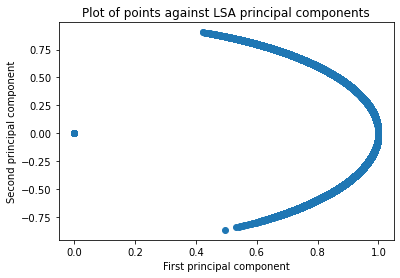

In [44]:
plt.figure()
plt.scatter(df['component_1'],df['component_2'])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Plot of points against LSA principal components')
plt.show()

## Multinomial Naive Bayes

In [20]:
from sklearn.naive_bayes import MultinomialNB

In [21]:
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

MultinomialNB()

In [22]:
predicted_categories = model.predict(X_val_tfidf)

In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
sns.set() # use seaborn plotting style

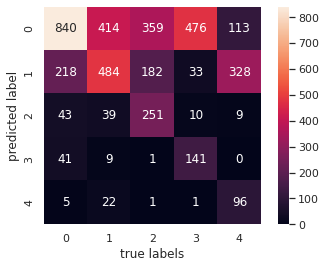

The accuracy is 0.4402332361516035


In [24]:
# plot the confusion matrix
mat = confusion_matrix(y_val, predicted_categories)
sns.heatmap(mat.T, square = True, annot=True, fmt = "d")
plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()
print("The accuracy is {}".format(accuracy_score(y_val, predicted_categories)))

In [25]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [26]:
lsa = TruncatedSVD(10)
svc = SVC(kernel='rbf',class_weight='balanced')

In [27]:
model = make_pipeline(lsa, svc)

In [ ]:
param_grid = {'svc__C': [1,5,10,50], 'svc__gamma': [0.0001,0.0005,0.001,0.005]}
grid = GridSearchCV(model, param_grid)
grid.fit(X_train_tfidf, y_train)
print(grid.best_params_)

# BERT Tokenizing and Fine-Tuned BERT

In [ ]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In order to apply the pre-trained BERT, we must use the tokenizer provided by the library. This is because (1) the model has a specific, fixed vocabulary and (2) the BERT tokenizer has a particular way of handling out-of-vocabulary words.

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:

        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [ ]:
# Concatenate train data and test data
all_tweets = np.concatenate([data.tweet.values, test_data.tweet.values])

# Encode our concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

In [ ]:
# Specify `MAX_LEN`
MAX_LEN = 64

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

BERT-base consists of 12 transformer layers, each transformer layer takes in a list of token embeddings, and produces the same number of embeddings with the same hidden size (or dimensions) on the output. The output of the final transformer layer of the [CLS] token is used as the features of the sequence to feed a classifier.

The transformers library has the BertForSequenceClassification class which is designed for classification tasks. However, we will create a new class so we can specify our own choice of classifiers.

Below we will create a BertClassifier class with a BERT model to extract the last hidden layer of the [CLS] token and a single-hidden-layer feed-forward neural network as our classifier.

In [ ]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits        

# BERT from Scratch / Encoder-only Attention Model

In [ ]:
import math
import re
from random import *
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
text = (
        'Hello, how are you? I am Romeo.\n'
        'Hello, Romeo My name is Juliet. Nice to meet you.\n'
        'Nice meet you too. How are you today?\n'
        'Great. My baseball team won the competition.\n'
        'Oh Congratulations, Juliet\n'
        'Thanks you Romeo'
    )

In [ ]:
sentences = re.sub("[.,!?\\-]", '', text.lower()).split('\n')  # filter '.', ',', '?', '!'
word_list = list(set(" ".join(sentences).split()))
word_dict = {'[PAD]': 0, '[CLS]': 1, '[SEP]': 2, '[MASK]': 3}


for i, w in enumerate(word_list):
    word_dict[w] = i + 4
number_dict = {i: w for i, w in enumerate(word_dict)}
vocab_size = len(word_dict)

token_list = list()
for sentence in sentences:
    arr = [word_dict[s] for s in sentence.split()]
    token_list.append(arr)

In [ ]:
maxlen = 30 # maximum of length
batch_size = 6
max_pred = 5  # max tokens of prediction
n_layers = 6 # number of Encoder of Encoder Layer
n_heads = 12 # number of heads in Multi-Head Attention
d_model = 768 # Embedding Size
d_ff = 768 * 4  # 4*d_model, FeedForward dimension
d_k = d_v = 64  # dimension of K(=Q), V
n_segments = 2
dropout_rate = 0.1

In [ ]:
def make_batch():
    batch = []
    positive = negative = 0
    while positive != batch_size/2 or negative != batch_size/2:
        tokens_a_index, tokens_b_index= randrange(len(sentences)), randrange(len(sentences))
        tokens_a, tokens_b= token_list[tokens_a_index], token_list[tokens_b_index]

        input_ids = [word_dict['[CLS]']] + tokens_a + [word_dict['[SEP]']] + tokens_b + [word_dict['[SEP]']]

        segment_ids = [0] * (1 + len(tokens_a) + 1) + [1] * (len(tokens_b) + 1)

        #MASK LM
        n_pred =  min(max_pred, max(1, int(round(len(input_ids) * 0.15)))) # 15 % of tokens in one sentence

        cand_maked_pos = [i for i, token in enumerate(input_ids)
                          if token != word_dict['[CLS]'] and token != word_dict['[SEP]']]
        shuffle(cand_maked_pos)
        masked_tokens, masked_pos = [], []
        for pos in cand_maked_pos[:n_pred]:
            masked_pos.append(pos)
            masked_tokens.append(input_ids[pos])
            if random() < 0.8:  # 80%
                input_ids[pos] = word_dict['[MASK]'] # make mask
            elif random() < 0.5:  # 10%
                index = randint(0, vocab_size - 1) # random index in vocabulary
                input_ids[pos] = word_dict[number_dict[index]] # replace

        # Zero Paddings
        n_pad = maxlen - len(input_ids)
        input_ids.extend([0] * n_pad)
        segment_ids.extend([0] * n_pad)

    #     # Zero Padding (100% - 15%) tokens
        if max_pred > n_pred:
            n_pad = max_pred - n_pred
            masked_tokens.extend([0] * n_pad)
            masked_pos.extend([0] * n_pad)

        if tokens_a_index + 1 == tokens_b_index and positive < batch_size/2:
            batch.append([input_ids, segment_ids, masked_tokens, masked_pos, True]) # IsNext
            positive += 1
        elif tokens_a_index + 1 != tokens_b_index and negative < batch_size/2:
            batch.append([input_ids, segment_ids, masked_tokens, masked_pos, False]) # NotNext
            negative += 1

    return batch

In [ ]:
def get_attn_pad_mask(seq_q, seq_k):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # eq(zero) is PAD token
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)  # batch_size x 1 x len_k(=len_q), one is masking
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # batch_size x len_q x len_k

In [ ]:
batch = make_batch()

In [ ]:
input_ids, segment_ids, masked_tokens, masked_pos, isNext = map(tf.constant, zip(*batch))

In [ ]:
input_ids

In [ ]:
class Embedding(tf.keras.layers.Layer):
    def __init__(self):
        super(Embedding, self).__init__()
        self.tok_embed = tf.keras.layers.Embedding(vocab_size, d_model)  # token embedding
        self.pos_embed = tf.keras.layers.Embedding(maxlen, d_model)  # position embedding
        self.seg_embed = tf.keras.layers.Embedding(n_segments, d_model)  # segment(token type) embedding
        self.norm = layers.LayerNormalization(d_model)

    def forward(self, x, seg):
        seq_len = x.size(1)
        pos = tf.experimental.numpy.arange(seq_len)
        pos = pos.unsqueeze(0).expand_as(x)  # (seq_len,) -> (batch_size, seq_len)
        embedding = self.tok_embed(x) + self.pos_embed(pos) + self.seg_embed(seg)
        return self.norm(embedding)

In [ ]:
def scaled_dot_product_attention(q,k,v,mask):
  matmul_qk = tf.matmul(q, k, transpose_b=True)
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention = matmul_qk / tf.math.sqrt(dk)
  # add the mask
  if mask is not None:
    scaled_attention += (mask * -1e9)
  
  attention_weights = tf.nn.softmax(scaled_attention, axis=-1)
  output = tf.matmul(attention_weights, v)

  return output, attention_weights

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0,2,1,3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model)
  ])

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    
    def __init__(self, d_model, FFN_units, n_heads, dropout_rate):
        super(EncoderLayer, self).__init__()
        self.FFN_units = FFN_units
        self.n_heads = n_heads
        self.d_model = d_model
        self.dropout_rate = dropout_rate
    
    def build(self, input_shape):
        # Build the multihead layer
        self.multi_head_attention = MultiHeadAttention(self.d_model, self.n_heads)
        self.ffn = point_wise_feed_forward_network(self.d_model, self.FFN_units)

        self.norm_1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = layers.LayerNormalization(epsilon=1e-6)

        self.dropout_1 = layers.Dropout(rate=self.dropout_rate)
        self.dropout_2 = layers.Dropout(rate=self.dropout_rate)
        
    def call(self, inputs, mask, training):
        # Forward pass of the multi-head attention
        attn_output, _ = self.multi_head_attention(inputs,
                                              inputs,
                                              inputs,
                                              mask)
        attn_output = self.dropout_1(attn_output, training=training)
        attn_output = self.norm_1(attn_output + inputs)
        outputs = self.ffn(attn_output)
        outputs = self.dropout_2(outputs, training=training)
        outputs = self.norm_2(outputs + attn_output)
        
        return outputs

In [ ]:
def torch_gather(x, indices, gather_axis):
    # if pytorch gather indices are
    # [[[0, 10, 20], [0, 10, 20], [0, 10, 20]],
    #  [[0, 10, 20], [0, 10, 20], [0, 10, 20]]]
    # tf nd_gather needs to be
    # [[0,0,0], [0,0,10], [0,0,20], [0,1,0], [0,1,10], [0,1,20], [0,2,0], [0,2,10], [0,2,20],
    #  [1,0,0], [1,0,10], [1,0,20], [1,1,0], [1,1,10], [1,1,20], [1,2,0], [1,2,10], [1,2,20]]

    # create a tensor containing indices of each element
    all_indices = tf.where(tf.fill(indices.shape, True))
    gather_locations = tf.reshape(indices, [indices.shape.num_elements()])

    # splice in our pytorch style index at the correct axis
    gather_indices = []
    for axis in range(len(indices.shape)):
        if axis == gather_axis:
            gather_indices.append(gather_locations)
        else:
            gather_indices.append(all_indices[:, axis])

    gather_indices = tf.stack(gather_indices, axis=-1)
    gathered = tf.gather_nd(x, gather_indices)
    reshaped = tf.reshape(gathered, indices.shape)
    return reshaped

In [ ]:
class BERT(tf.keras.layers.Layer):

    def __init__(self,
                 n_layers,
                 FFN_units,
                 n_heads,
                 dropout_rate,
                 vocab_size,
                 d_model,
                 name="BERT"):
      
        super(BERT, self).__init__(name=name)
        self.n_layers = n_layers
        self.d_model = d_model
        self.embedding = Embedding()
        self.layers = [EncoderLayer(d_model, FFN_units,
                                        n_heads,
                                        dropout_rate) 
                           for _ in range(n_layers)]
        
        self.fc = tf.keras.layers.Dense(d_model, input_shape=(d_model,), activation=None)
        self.linear = tf.keras.layers.Dense(d_model, input_shape=(d_model,), activation=None)
        self.norm = layers.LayerNormalization(d_model)
        self.classifier = tf.keras.layers.Dense(2, input_shape=(d_model,), activation=None)
        
        # decoder is shared with embedding layer
        embed_weight = self.embedding.tok_embed
        self.decoder = tf.keras.layers.Dense(d_model, input_shape=(vocab_size,), activation=None)
        self.decoder.weight = embed_weight
        # self.decoder_bias = nn.Parameter(torch.zeros(n_vocab))

    def forward(self, input_ids, segment_ids, masked_pos, training):
        output = self.embedding(input_ids, segment_ids)
        enc_self_attn_mask = get_attn_pad_mask(input_ids, input_ids)

        for layer in self.layers:
            output, enc_self_attn = layer(output, enc_self_attn_mask, training)
        # output : [batch_size, len, d_model], attn : [batch_size, n_heads, d_mode, d_model]
  
        h_pooled = tf.math.tanh(self.fc(output[:, 0])) # [batch_size, d_model]
        logits_clsf = self.classifier(h_pooled) # [batch_size, 2]

        masked_pos = masked_pos[:, :, None].expand(-1, -1, output.size(-1)) # [batch_size, max_pred, d_model]
        # get masked position from final output of transformer.
        
        h_masked = torch_gather(output, 1, masked_pos) # masking position [batch_size, max_pred, d_model]
        h_masked = self.norm(tf.keras.activations.gelu(self.linear(h_masked)))
        logits_lm = self.decoder(h_masked)

        return logits_lm, logits_clsf

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
model = BERT(    
    n_layers = n_layers,
    d_model = d_model,
    n_heads = n_heads,
    FFN_units = d_ff,
    vocab_size = vocab_size, 
    dropout_rate = dropout_rate)

learning_rate = CustomSchedule(d_model)
criterion = tf.keras.losses.SparseCategoricalCrossentropy(
                                    from_logits=True, reduction='none')
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

batch = make_batch()
input_ids, segment_ids, masked_tokens, masked_pos, isNext = map(tf.constant, zip(*batch))

for epoch in range(10):
  with tf.GradientTape() as tape:

    logits_lm, logits_clsf = model(input_ids, segment_ids, masked_pos)
    loss_lm = criterion(logits_lm.transpose(1, 2), masked_tokens) # for masked LM
    loss_lm = (loss_lm.float()).mean()
    loss_clsf = criterion(logits_clsf, isNext) # for sentence classification
    loss = loss_lm + loss_clsf

  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  if (epoch + 1) % 10 == 0:
      print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))
  loss.backward()
  optimizer.step()